# NB09: Final Synthesis — Darkness Spectrum, Minimum Covering Set & Experimental Call to Action

**Purpose**: Synthesize all evidence from NB01–NB08 into three actionable deliverables for experimentalists:

1. **Darkness Spectrum** — classify all 57,011 dark genes by "how dark they are" (T1 Void → T5 Dawn)
2. **Minimum Covering Set** — greedy weighted set-cover to select the fewest organisms that cover the most high-priority dark genes
3. **Experimental Action Plan** — per-organism condition recommendations (hypothesis-bearing vs. broad screen)

**Inputs** (all from prior notebooks):
- `data/dark_genes_only.tsv` (NB01, 57,011 dark genes)
- `data/gene_neighbor_context.tsv` (NB07, 57,011 neighbor profiles)
- `data/scoring_all_dark.tsv` (NB05, 17,344 fitness-active scored)
- `data/essential_dark_scored.tsv` (NB07, 9,557 essential scored)
- `data/improved_candidates.tsv` (NB08, 300 re-scored candidates)
- `data/conserved_neighborhoods.tsv` (NB08, 21,011 synteny pairs)
- `data/cofit_validated_operons.tsv` (NB08, 32,075 cofit pairs)
- `data/prioritized_candidates.tsv` (NB05, 100 top candidates)
- `data/essential_prioritized_candidates.tsv` (NB07, 50 essential candidates)
- `data/concordance_scores.tsv` (NB02, 65 concordant OGs)

**Outputs**:
- `data/dark_gene_census_full.tsv` — 57,011 rows with tier + evidence flags + composite score
- `data/minimum_covering_set.tsv` — gene-to-organism assignments from set cover
- `data/experimental_action_plan.tsv` — per-organism condition recommendations
- `figures/fig25_darkness_spectrum.png`
- `figures/fig26_covering_set.png`
- `figures/fig27_action_plan.png`

**Dependencies**: pandas, numpy, matplotlib, seaborn (no Spark needed)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Project paths
if os.path.basename(os.getcwd()) == 'notebooks':
    PROJECT_DIR = os.path.dirname(os.getcwd())
else:
    PROJECT_DIR = os.getcwd()

DATA_DIR = os.path.join(PROJECT_DIR, 'data')
FIG_DIR = os.path.join(PROJECT_DIR, 'figures')
os.makedirs(FIG_DIR, exist_ok=True)

print(f'Project dir: {PROJECT_DIR}')

Project dir: /home/aparkin/BERIL-research-observatory/projects/functional_dark_matter


In [2]:
# Load all upstream data
dark = pd.read_csv(os.path.join(DATA_DIR, 'dark_genes_only.tsv'), sep='\t', low_memory=False)
dark['locusId'] = dark['locusId'].astype(str)
print(f'Dark genes: {len(dark):,}')

neighbors = pd.read_csv(os.path.join(DATA_DIR, 'gene_neighbor_context.tsv'), sep='\t')
neighbors['locusId'] = neighbors['locusId'].astype(str)
print(f'Neighbor context: {len(neighbors):,}')

scoring_active = pd.read_csv(os.path.join(DATA_DIR, 'scoring_all_dark.tsv'), sep='\t')
scoring_active['locusId'] = scoring_active['locusId'].astype(str)
print(f'Fitness-active scored: {len(scoring_active):,}')

scoring_essential = pd.read_csv(os.path.join(DATA_DIR, 'essential_dark_scored.tsv'), sep='\t')
scoring_essential['locusId'] = scoring_essential['locusId'].astype(str)
print(f'Essential scored: {len(scoring_essential):,}')

improved = pd.read_csv(os.path.join(DATA_DIR, 'improved_candidates.tsv'), sep='\t')
improved['locusId'] = improved['locusId'].astype(str)
print(f'Improved candidates: {len(improved):,}')

conserved_nbrs = pd.read_csv(os.path.join(DATA_DIR, 'conserved_neighborhoods.tsv'), sep='\t')
conserved_nbrs['dark_locusId'] = conserved_nbrs['dark_locusId'].astype(str)
print(f'Conserved neighborhoods: {len(conserved_nbrs):,}')

cofit_operons = pd.read_csv(os.path.join(DATA_DIR, 'cofit_validated_operons.tsv'), sep='\t')
cofit_operons['dark_locusId'] = cofit_operons['dark_locusId'].astype(str)
print(f'Cofit-validated operons: {len(cofit_operons):,}')

prioritized = pd.read_csv(os.path.join(DATA_DIR, 'prioritized_candidates.tsv'), sep='\t')
prioritized['locusId'] = prioritized['locusId'].astype(str)
print(f'Prioritized candidates: {len(prioritized):,}')

ess_prioritized = pd.read_csv(os.path.join(DATA_DIR, 'essential_prioritized_candidates.tsv'), sep='\t')
ess_prioritized['locusId'] = ess_prioritized['locusId'].astype(str)
print(f'Essential prioritized: {len(ess_prioritized):,}')

concordance = pd.read_csv(os.path.join(DATA_DIR, 'concordance_scores.tsv'), sep='\t')
print(f'Concordance scores: {len(concordance):,}')

Dark genes: 57,011


Neighbor context: 57,011


Fitness-active scored: 17,344
Essential scored: 9,557
Improved candidates: 300
Conserved neighborhoods: 21,011
Cofit-validated operons: 32,075
Prioritized candidates: 100
Essential prioritized: 50
Concordance scores: 65


## Section 1: Darkness Spectrum

Classify all 57,011 dark genes into five tiers based on how many independent lines of evidence exist:

| Tier | Name | Evidence Lines | Interpretation |
|------|------|---------------|----------------|
| T1 | Void | 0 | Truly unknown — no evidence of any kind |
| T2 | Twilight | 1 | Single clue (usually just OG or domain) |
| T3 | Dusk | 2 | Partial picture — converging hints |
| T4 | Penumbra | 3–4 | Substantial evidence — testable hypotheses |
| T5 | Dawn | 5–6 | Nearly characterized — approaching annotation |

In [3]:
# Compute 6 evidence flags for each dark gene
census = dark[['orgId', 'locusId', 'sysName', 'gene', 'desc', 'annotation_class']].copy()

# Flag 1: has_domain — n_domains > 0
census = census.merge(
    dark[['orgId', 'locusId', 'n_domains']],
    on=['orgId', 'locusId'], how='left'
)
census['has_domain'] = census['n_domains'].fillna(0).astype(int) > 0

# Flag 2: has_ortholog_group — OG_id assigned
census = census.merge(
    dark[['orgId', 'locusId', 'OG_id']],
    on=['orgId', 'locusId'], how='left'
)
census['has_ortholog_group'] = census['OG_id'].notna() & (census['OG_id'] != '')

# Flag 3: has_function_prediction — module_prediction exists
census = census.merge(
    dark[['orgId', 'locusId', 'module_prediction']],
    on=['orgId', 'locusId'], how='left'
)
census['has_function_prediction'] = census['module_prediction'].notna() & (census['module_prediction'] != '')

# Flag 4: has_cofit_partner — top_cofit_score > 0
census = census.merge(
    dark[['orgId', 'locusId', 'top_cofit_score', 'top_cofit_partners']],
    on=['orgId', 'locusId'], how='left'
)
census['has_cofit_partner'] = census['top_cofit_score'].fillna(0) > 0

# Flag 5: has_phenotype — |fit| >= 2.0 OR is_essential_dark
census = census.merge(
    dark[['orgId', 'locusId', 'max_abs_fit', 'is_essential_dark']],
    on=['orgId', 'locusId'], how='left'
)
census['has_phenotype'] = (census['max_abs_fit'].fillna(0) >= 2.0) | (census['is_essential_dark'] == True)

# Flag 6: has_pangenome_context — has_pangenome_link == True
census = census.merge(
    dark[['orgId', 'locusId', 'has_pangenome_link']],
    on=['orgId', 'locusId'], how='left'
)
census['has_pangenome_context'] = census['has_pangenome_link'] == True

# Count evidence lines and assign tier
evidence_flags = ['has_domain', 'has_ortholog_group', 'has_function_prediction',
                  'has_cofit_partner', 'has_phenotype', 'has_pangenome_context']
census['n_evidence_lines'] = census[evidence_flags].sum(axis=1)

def assign_tier(n):
    if n == 0: return 'T1_Void'
    elif n == 1: return 'T2_Twilight'
    elif n == 2: return 'T3_Dusk'
    elif n <= 4: return 'T4_Penumbra'
    else: return 'T5_Dawn'

census['darkness_tier'] = census['n_evidence_lines'].apply(assign_tier)

# Merge neighbor-based qualifiers
nbr_quals = neighbors[['orgId', 'locusId', 'neighbor_functional_inference',
                        'n_operon_annotated', 'func_keywords']].copy()
census = census.merge(nbr_quals, on=['orgId', 'locusId'], how='left')
census['has_neighbor_inference'] = (
    census['neighbor_functional_inference'].notna() &
    (census['neighbor_functional_inference'] != '')
)

# Synteny qualifier: any conserved neighborhood pair with conservation_score > 0.3
synteny_genes = conserved_nbrs[conserved_nbrs['conservation_score'] > 0.3].groupby(
    ['orgId', 'dark_locusId']
).size().reset_index(name='n_synteny_pairs')
synteny_genes = synteny_genes.rename(columns={'dark_locusId': 'locusId'})
census = census.merge(synteny_genes[['orgId', 'locusId', 'n_synteny_pairs']],
                      on=['orgId', 'locusId'], how='left')
census['has_synteny_support'] = census['n_synteny_pairs'].fillna(0) > 0

# Cofit operon qualifier: any validated operon with cofit_score > 0.5
cofit_genes = cofit_operons[cofit_operons['cofit_score'] > 0.5].groupby(
    ['orgId', 'dark_locusId']
).size().reset_index(name='n_cofit_pairs')
cofit_genes = cofit_genes.rename(columns={'dark_locusId': 'locusId'})
census = census.merge(cofit_genes[['orgId', 'locusId', 'n_cofit_pairs']],
                      on=['orgId', 'locusId'], how='left')
census['has_cofit_operon'] = census['n_cofit_pairs'].fillna(0) > 0

# Concordance qualifier: OG in concordance_scores
concordant_ogs = set(concordance['ogId'].astype(str).values)
census['has_concordance'] = census['OG_id'].astype(str).isin(concordant_ogs)

# Print tier distribution
print('Darkness Tier Distribution:')
tier_counts = census['darkness_tier'].value_counts().sort_index()
for tier, count in tier_counts.items():
    print(f'  {tier:15s}: {count:>6,} ({100*count/len(census):.1f}%)')
print(f'  {"Total":15s}: {len(census):>6,}')

print(f'\nEvidence line distribution:')
ev_counts = census['n_evidence_lines'].value_counts().sort_index()
for n, count in ev_counts.items():
    print(f'  {n} flags: {count:>6,}')

print(f'\nQualifier summary:')
for q in ['has_synteny_support', 'has_cofit_operon', 'has_neighbor_inference', 'has_concordance']:
    n = census[q].sum()
    print(f'  {q:25s}: {n:>6,} ({100*n/len(census):.1f}%)')

Darkness Tier Distribution:
  T1_Void        :  4,273 (7.5%)
  T2_Twilight    : 12,282 (21.5%)
  T3_Dusk        : 16,103 (28.2%)
  T4_Penumbra    : 22,500 (39.5%)
  T5_Dawn        :  1,853 (3.3%)
  Total          : 57,011

Evidence line distribution:
  0 flags:  4,273
  1 flags: 12,282
  2 flags: 16,103
  3 flags: 15,937
  4 flags:  6,563
  5 flags:  1,853

Qualifier summary:
  has_synteny_support      : 12,009 (21.1%)
  has_cofit_operon         :  1,774 (3.1%)
  has_neighbor_inference   : 55,422 (97.2%)
  has_concordance          :      0 (0.0%)


In [4]:
# Merge composite scores from NB05 (active), NB07 (essential), NB08 (improved)
# Priority: improved_score > active_score > essential_score

# NB08 improved candidates
improved_scores = improved[['orgId', 'locusId', 'total_score', 'candidate_type']].copy()
improved_scores = improved_scores.rename(columns={'total_score': 'improved_score'})

# NB05 fitness-active scores
active_scores = scoring_active[['orgId', 'locusId', 'total_score']].copy()
active_scores = active_scores.rename(columns={'total_score': 'active_score'})

# NB07 essential scores
essential_scores = scoring_essential[['orgId', 'locusId', 'total_score']].copy()
essential_scores = essential_scores.rename(columns={'total_score': 'essential_score'})

# Merge all scores onto census
census = census.merge(improved_scores, on=['orgId', 'locusId'], how='left')
census = census.merge(active_scores, on=['orgId', 'locusId'], how='left')
census = census.merge(essential_scores, on=['orgId', 'locusId'], how='left')

# Unified composite: improved > active > essential
census['composite_score'] = census['improved_score'].fillna(
    census['active_score'].fillna(
        census['essential_score']
    )
)

# Track score source
def get_score_source(row):
    if pd.notna(row['improved_score']):
        return 'improved'
    elif pd.notna(row['active_score']):
        return 'active'
    elif pd.notna(row['essential_score']):
        return 'essential'
    return 'none'

census['score_source'] = census.apply(get_score_source, axis=1)

# Also merge top_condition from scoring_active
census = census.merge(
    scoring_active[['orgId', 'locusId', 'top_condition_class', 'top_condition_fit']],
    on=['orgId', 'locusId'], how='left'
)

print('Score source distribution:')
source_counts = census['score_source'].value_counts()
for src, n in source_counts.items():
    print(f'  {src:12s}: {n:>6,}')

scored_mask = census['composite_score'].notna()
print(f'\nGenes with composite score: {scored_mask.sum():,}')
print(f'Genes without score: {(~scored_mask).sum():,}')
print(f'Score range: {census.loc[scored_mask, "composite_score"].min():.3f} – '
      f'{census.loc[scored_mask, "composite_score"].max():.3f}')

Score source distribution:
  none        : 39,667
  active      : 17,044
  improved    :    300

Genes with composite score: 17,344
Genes without score: 39,667
Score range: 0.048 – 0.899


In [5]:
# Build evidence_summary text column
def build_evidence_summary(row):
    parts = []
    if row.get('has_domain'):
        nd = int(row.get('n_domains', 0))
        parts.append(f'{nd} domain(s)')
    if row.get('has_ortholog_group'):
        parts.append(f'OG:{row["OG_id"]}')
    if row.get('has_function_prediction'):
        pred = str(row.get('module_prediction', ''))
        parts.append(f'pred:{pred[:40]}')
    if row.get('has_cofit_partner'):
        partner = str(row.get('top_cofit_partners', ''))
        parts.append(f'cofit:{partner[:30]}')
    if row.get('has_phenotype'):
        if row.get('is_essential_dark') == True:
            parts.append('essential')
        else:
            fit = row.get('max_abs_fit', 0)
            cond = str(row.get('top_condition_class', ''))
            if pd.notna(fit) and fit > 0:
                parts.append(f'fit:{fit:.1f}({cond[:15]})')
            else:
                parts.append('phenotype')
    if row.get('has_pangenome_context'):
        parts.append('pangenome')
    # Qualifiers
    quals = []
    if row.get('has_synteny_support'): quals.append('synteny')
    if row.get('has_cofit_operon'): quals.append('cofit_operon')
    if row.get('has_concordance'): quals.append('concordance')
    if row.get('has_neighbor_inference'): quals.append('neighbor_inf')
    if quals:
        parts.append('+' + ','.join(quals))
    return '; '.join(parts) if parts else 'none'

census['evidence_summary'] = census.apply(build_evidence_summary, axis=1)

# Sort: darkest-first (T1 first, within tier by lack of score)
tier_order = {'T1_Void': 0, 'T2_Twilight': 1, 'T3_Dusk': 2, 'T4_Penumbra': 3, 'T5_Dawn': 4}
census['tier_rank'] = census['darkness_tier'].map(tier_order)
census = census.sort_values(['tier_rank', 'composite_score'],
                            ascending=[True, True], na_position='first').reset_index(drop=True)

# Select output columns
output_cols = [
    'orgId', 'locusId', 'sysName', 'gene', 'desc', 'annotation_class',
    'darkness_tier', 'n_evidence_lines',
    'has_domain', 'has_ortholog_group', 'has_function_prediction',
    'has_cofit_partner', 'has_phenotype', 'has_pangenome_context',
    'has_synteny_support', 'has_cofit_operon', 'has_neighbor_inference', 'has_concordance',
    'composite_score', 'score_source',
    'n_domains', 'OG_id', 'module_prediction', 'top_cofit_partners',
    'max_abs_fit', 'is_essential_dark', 'has_pangenome_link',
    'top_condition_class', 'top_condition_fit',
    'evidence_summary'
]
census_out = census[output_cols].copy()

census_out.to_csv(os.path.join(DATA_DIR, 'dark_gene_census_full.tsv'), sep='\t', index=False)
print(f'Saved dark_gene_census_full.tsv ({len(census_out):,} rows, {len(output_cols)} columns)')

# Verify
print(f'\nVerification:')
print(f'  Tier counts sum: {census["darkness_tier"].value_counts().sum():,} (expected 57,011)')
print(f'  T1 evidence_summary=none: {(census_out[census_out["darkness_tier"]=="T1_Void"]["evidence_summary"]=="none").sum():,}')
print(f'  T5 genes: {(census_out["darkness_tier"]=="T5_Dawn").sum():,}')
print(f'\nSample T1 (Void):')
print(census_out[census_out['darkness_tier'] == 'T1_Void'][['orgId', 'locusId', 'desc', 'evidence_summary']].head(3).to_string())
print(f'\nSample T5 (Dawn):')
print(census_out[census_out['darkness_tier'] == 'T5_Dawn'][['orgId', 'locusId', 'desc', 'composite_score', 'evidence_summary']].head(3).to_string())

Saved dark_gene_census_full.tsv (57,011 rows, 30 columns)

Verification:
  Tier counts sum: 57,011 (expected 57,011)
  T1 evidence_summary=none: 58
  T5 genes: 1,853

Sample T1 (Void):
             orgId     locusId                  desc evidence_summary
0  acidovorax_3H11    Ac3H11_8  hypothetical protein    +neighbor_inf
1  acidovorax_3H11   Ac3H11_92  hypothetical protein    +neighbor_inf
2  acidovorax_3H11  Ac3H11_267  hypothetical protein    +neighbor_inf

Sample T5 (Dawn):
      orgId   locusId                           desc  composite_score                                                                                                 evidence_summary
55158   DvH  11399177                            NaN         0.424905              2 domain(s); OG:OG08624; pred:TIGR02532; fit:2.3(respiratory gro); pangenome; +synteny,neighbor_inf
55159   PV4   5209211  hypothetical protein (RefSeq)         0.428853  1 domain(s); OG:OG05253; cofit:porin (RefSeq) | glycerophosph; fit:2.2(carbon s

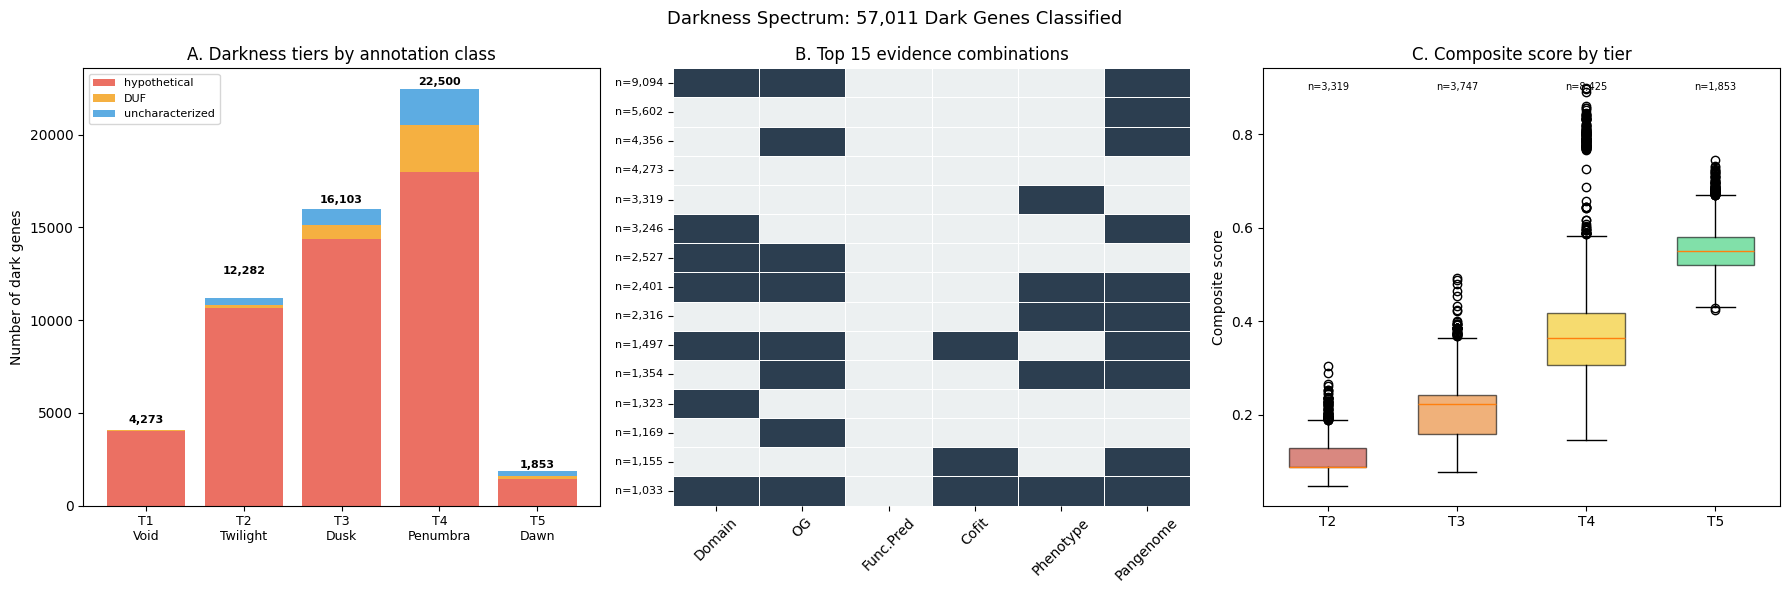

Saved fig25_darkness_spectrum.png


In [6]:
# Figure 25: Darkness Spectrum
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Panel A: Tier bar chart colored by annotation_class
ax = axes[0]
tier_names = ['T1_Void', 'T2_Twilight', 'T3_Dusk', 'T4_Penumbra', 'T5_Dawn']
tier_labels = ['T1\nVoid', 'T2\nTwilight', 'T3\nDusk', 'T4\nPenumbra', 'T5\nDawn']
annot_classes = ['hypothetical', 'DUF', 'uncharacterized']
class_colors = {'hypothetical': '#e74c3c', 'DUF': '#f39c12', 'uncharacterized': '#3498db'}

bottom = np.zeros(len(tier_names))
for ac in annot_classes:
    counts = []
    for tier in tier_names:
        mask = (census['darkness_tier'] == tier) & (census['annotation_class'] == ac)
        counts.append(mask.sum())
    ax.bar(range(len(tier_names)), counts, bottom=bottom,
           label=ac, color=class_colors.get(ac, 'gray'), alpha=0.8)
    bottom += np.array(counts)

ax.set_xticks(range(len(tier_names)))
ax.set_xticklabels(tier_labels, fontsize=9)
ax.set_ylabel('Number of dark genes')
ax.set_title('A. Darkness tiers by annotation class')
ax.legend(fontsize=8)
# Add count labels
for i, tier in enumerate(tier_names):
    total = (census['darkness_tier'] == tier).sum()
    ax.text(i, total + 200, f'{total:,}', ha='center', fontsize=8, fontweight='bold')

# Panel B: Top 15 evidence flag combinations as binary heatmap + count bars
ax = axes[1]
flag_cols = ['has_domain', 'has_ortholog_group', 'has_function_prediction',
             'has_cofit_partner', 'has_phenotype', 'has_pangenome_context']
flag_short = ['Domain', 'OG', 'Func.Pred', 'Cofit', 'Phenotype', 'Pangenome']

combo_strs = census[flag_cols].astype(int).astype(str).agg(''.join, axis=1)
combo_counts = combo_strs.value_counts().head(15)

# Build heatmap matrix
heatmap_data = []
combo_labels = []
combo_ns = []
for combo_str, count in combo_counts.items():
    heatmap_data.append([int(c) for c in combo_str])
    combo_labels.append(f'n={count:,}')
    combo_ns.append(count)

heatmap_arr = np.array(heatmap_data)
sns.heatmap(heatmap_arr, ax=ax, cmap=['#ecf0f1', '#2c3e50'],
            xticklabels=flag_short, yticklabels=combo_labels,
            cbar=False, linewidths=0.5, linecolor='white')
ax.set_title('B. Top 15 evidence combinations')
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', labelsize=8)

# Panel C: Composite score boxplots by tier
ax = axes[2]
scored_census = census[census['composite_score'].notna()].copy()
tier_data = [scored_census[scored_census['darkness_tier'] == t]['composite_score'].values
             for t in tier_names if len(scored_census[scored_census['darkness_tier'] == t]) > 0]
tier_present = [t for t in tier_names if len(scored_census[scored_census['darkness_tier'] == t]) > 0]

bp = ax.boxplot(tier_data, patch_artist=True, widths=0.6)
tier_colors = ['#c0392b', '#e67e22', '#f1c40f', '#2ecc71', '#3498db']
for patch, color in zip(bp['boxes'], tier_colors[:len(tier_present)]):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

short_labels = [t.split('_')[0] for t in tier_present]
ax.set_xticklabels(short_labels)
ax.set_ylabel('Composite score')
ax.set_title('C. Composite score by tier')
# Add n= annotations
for i, t in enumerate(tier_present):
    n = len(scored_census[scored_census['darkness_tier'] == t])
    ax.text(i + 1, ax.get_ylim()[1] * 0.95, f'n={n:,}', ha='center', fontsize=7)

plt.suptitle(f'Darkness Spectrum: {len(census):,} Dark Genes Classified', fontsize=13)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'fig25_darkness_spectrum.png'), dpi=150, bbox_inches='tight')
plt.show()
plt.show()
print('Saved fig25_darkness_spectrum.png')

## Section 2: Minimum Covering Set

Select the fewest organisms that cover the most high-priority dark genes, using greedy weighted set-cover:
- **Universe**: scored genes with composite_score (fitness-active + essential, deduplicated)
- **Objective per step**: select organism maximizing `sum_uncovered_priority × tractability × phylo_bonus`
- **Stop**: when 95% of total priority-value is covered

In [7]:
# Define set-cover universe: scored genes with composite_score
universe = census[census['composite_score'].notna()][['orgId', 'locusId', 'composite_score', 'darkness_tier']].copy()
universe['gene_key'] = universe['orgId'] + ':' + universe['locusId']
print(f'Set-cover universe: {len(universe):,} genes with composite scores')
print(f'Total priority value: {universe["composite_score"].sum():.1f}')
print(f'\nTier distribution in universe:')
print(universe['darkness_tier'].value_counts().sort_index().to_string())

# Build org_sets: {orgId -> {gene_key: priority_value}}
org_sets = {}
for _, row in universe.iterrows():
    org = row['orgId']
    if org not in org_sets:
        org_sets[org] = {}
    org_sets[org][row['gene_key']] = row['composite_score']

print(f'\nOrganisms in universe: {len(org_sets)}')
print(f'\nTop 10 organisms by gene count:')
org_gene_counts = sorted(org_sets.items(), key=lambda x: len(x[1]), reverse=True)[:10]
for org, genes in org_gene_counts:
    print(f'  {org:25s}: {len(genes):>5,} genes, sum_priority={sum(genes.values()):.1f}')

Set-cover universe: 17,344 genes with composite scores
Total priority value: 5250.0

Tier distribution in universe:
darkness_tier
T2_Twilight    3319
T3_Dusk        3747
T4_Penumbra    8425
T5_Dawn        1853



Organisms in universe: 48

Top 10 organisms by gene count:
  azobra                   :   897 genes, sum_priority=188.9
  Dino                     :   709 genes, sum_priority=169.3
  Btheta                   :   693 genes, sum_priority=249.8
  Miya                     :   653 genes, sum_priority=108.0
  pseudo1_N1B4             :   624 genes, sum_priority=193.7
  BFirm                    :   600 genes, sum_priority=171.0
  MR1                      :   587 genes, sum_priority=257.8
  Smeli                    :   570 genes, sum_priority=221.1
  DvH                      :   545 genes, sum_priority=132.1
  Magneto                  :   460 genes, sum_priority=45.5


In [8]:
# CRISPRi tractability dict (from NB07)
CRISPRI_TRACTABILITY = {
    'Keio': 0.9, 'BW25113': 0.9, 'Deshi': 0.85,
    'MR1': 0.8, 'SB2B': 0.7,
    'Putida': 0.8, 'pseudo5_N2C3_1': 0.75,
    'pseudo1_N1B4': 0.7, 'pseudo3_N2E2': 0.7,
    'pseudo13_GW456_L13': 0.65,
    'Pse': 0.7, 'Pseu': 0.7,
    'BT': 0.75, 'Bacteroides_theta': 0.75,
    'Smeli': 0.6, 'Koxy': 0.65,
    'Marino': 0.5, 'DvH': 0.5,
    'Geobacter': 0.45, 'Caulobacter': 0.6,
    'Synpcc7942': 0.55, 'Synpcc6803': 0.55,
    'psRCH2': 0.55, 'Rleg': 0.5,
}
DEFAULT_CRISPRI = 0.3

# Genus mapping from orgId — load from organism_mapping.tsv
BASE = os.path.dirname(PROJECT_DIR)  # observatory/projects/
org_map = pd.read_csv(os.path.join(BASE, 'conservation_vs_fitness', 'data', 'organism_mapping.tsv'), sep='\t')
ORG_GENUS = dict(zip(org_map['orgId'], org_map['genus']))
# Manual fallbacks for 4 organisms not in organism_mapping.tsv
ORG_GENUS.setdefault('SB2B', 'Shewanella')
ORG_GENUS.setdefault('Magneto', 'Magnetospirillum')
ORG_GENUS.setdefault('Cola', 'Echinicola')
ORG_GENUS.setdefault('Kang', 'Kangiella')

# Check which organisms are in the universe
orgs_in_universe = set(org_sets.keys())
mapped = sum(1 for o in orgs_in_universe if o in ORG_GENUS)
print(f'Organisms in universe: {len(orgs_in_universe)}')
print(f'With genus mapping: {mapped}')
print(f'Without mapping: {len(orgs_in_universe) - mapped}')
unmapped = [o for o in orgs_in_universe if o not in ORG_GENUS]
if unmapped:
    print(f'Unmapped organisms: {unmapped}')
    # Default unmapped to their orgId as genus proxy
    for o in unmapped:
        ORG_GENUS[o] = o

print(f'\nGenus distribution in universe:')
genus_counts = Counter(ORG_GENUS.get(o, o) for o in orgs_in_universe)
for g, n in genus_counts.most_common(10):
    print(f'  {g}: {n} organisms')

Organisms in universe: 48
With genus mapping: 48
Without mapping: 0

Genus distribution in universe:
  Pseudomonas: 10 organisms
  Shewanella: 4 organisms
  Ralstonia: 4 organisms
  Dickeya: 3 organisms
  Desulfovibrio: 2 organisms
  Methanococcus: 2 organisms
  Pontibacter: 1 organisms
  Dechlorosoma: 1 organisms
  Dyella: 1 organisms
  Phaeobacter: 1 organisms


In [9]:
# Greedy weighted set-cover
total_priority = universe['composite_score'].sum()
target_coverage = 0.95 * total_priority

uncovered = set(universe['gene_key'].values)
covered_priority = 0.0
selected_genera = set()
covering_sequence = []  # list of dicts recording each step

gene_priority = dict(zip(universe['gene_key'], universe['composite_score']))

step = 0
while covered_priority < target_coverage and uncovered:
    best_org = None
    best_value = -1
    best_uncovered_genes = []
    best_sum_priority = 0

    for org, gene_dict in org_sets.items():
        # Genes in this organism that are still uncovered
        org_uncovered = [g for g in gene_dict if g in uncovered]
        if not org_uncovered:
            continue

        sum_priority = sum(gene_priority[g] for g in org_uncovered)
        tractability = CRISPRI_TRACTABILITY.get(org, DEFAULT_CRISPRI)
        genus = ORG_GENUS.get(org, org)
        phylo_bonus = 0.5 if genus in selected_genera else 1.0

        value = sum_priority * tractability * phylo_bonus

        if value > best_value:
            best_value = value
            best_org = org
            best_uncovered_genes = org_uncovered
            best_sum_priority = sum_priority

    if best_org is None:
        break

    step += 1
    genus = ORG_GENUS.get(best_org, best_org)
    tractability = CRISPRI_TRACTABILITY.get(best_org, DEFAULT_CRISPRI)
    phylo_bonus = 0.5 if genus in selected_genera else 1.0

    # Update state
    for g in best_uncovered_genes:
        uncovered.discard(g)
    covered_priority += best_sum_priority
    selected_genera.add(genus)

    covering_sequence.append({
        'step': step,
        'orgId': best_org,
        'genus': genus,
        'n_new_genes': len(best_uncovered_genes),
        'sum_priority': best_sum_priority,
        'tractability': tractability,
        'phylo_bonus': phylo_bonus,
        'objective_value': best_value,
        'cumulative_genes': len(universe) - len(uncovered),
        'cumulative_priority': covered_priority,
        'pct_covered': 100 * covered_priority / total_priority,
    })

covering_df = pd.DataFrame(covering_sequence)

print(f'Set-cover completed in {step} steps')
print(f'Coverage: {covered_priority:.1f} / {total_priority:.1f} '
      f'({100*covered_priority/total_priority:.1f}%)')
print(f'Unique genera: {len(selected_genera)}')
print(f'\nCovering table:')
print(covering_df[['step', 'orgId', 'genus', 'n_new_genes', 'tractability',
                    'pct_covered']].to_string(index=False))

Set-cover completed in 42 steps
Coverage: 5008.8 / 5250.0 (95.4%)
Unique genera: 28

Covering table:
 step                   orgId            genus  n_new_genes  tractability  pct_covered
    1                     MR1       Shewanella          587          0.80     4.910424
    2            pseudo1_N1B4      Pseudomonas          624          0.70     8.600666
    3                   Smeli    Sinorhizobium          570          0.60    12.811695
    4                    Keio      Escherichia          368          0.90    14.872291
    5                    Koxy       Klebsiella          396          0.65    17.532781
    6                  Btheta      Bacteroides          693          0.30    22.290163
    7                     DvH    Desulfovibrio          545          0.50    24.806530
    8                  azobra     Azospirillum          897          0.30    28.404055
    9                  Putida      Pseudomonas          327          0.80    30.884371
   10                   BFirm

In [10]:
# Build gene-to-organism assignment table
# Each gene assigned to first covering organism (in order of selection)
gene_assignments = []
assigned_genes = set()

for row in covering_sequence:
    org = row['orgId']
    gene_dict = org_sets[org]
    for gene_key, priority in gene_dict.items():
        if gene_key not in assigned_genes:
            assigned_genes.add(gene_key)
            org_id, locus_id = gene_key.split(':', 1)
            gene_assignments.append({
                'orgId': org_id,
                'locusId': locus_id,
                'assigned_organism': org,
                'covering_step': row['step'],
                'composite_score': priority,
            })

assignments_df = pd.DataFrame(gene_assignments)

# Merge tier + evidence from census
assignments_df = assignments_df.merge(
    census[['orgId', 'locusId', 'desc', 'darkness_tier', 'n_evidence_lines',
            'evidence_summary', 'annotation_class', 'is_essential_dark',
            'top_condition_class']],
    on=['orgId', 'locusId'], how='left'
)

assignments_df.to_csv(os.path.join(DATA_DIR, 'minimum_covering_set.tsv'), sep='\t', index=False)
print(f'Saved minimum_covering_set.tsv ({len(assignments_df):,} genes assigned)')
print(f'\nAssignment summary by covering organism:')
for _, step_row in covering_df.iterrows():
    org = step_row['orgId']
    org_assigned = assignments_df[assignments_df['assigned_organism'] == org]
    tiers = org_assigned['darkness_tier'].value_counts().to_dict()
    n_ess = org_assigned['is_essential_dark'].fillna(False).sum()
    print(f'  Step {int(step_row["step"]):2d} {org:25s}: {len(org_assigned):>5,} genes '
          f'(ess={n_ess:>3}), tiers: {dict(sorted(tiers.items()))}')

Saved minimum_covering_set.tsv (16,488 genes assigned)

Assignment summary by covering organism:
  Step  1 MR1                      :   587 genes (ess=190), tiers: {'T2_Twilight': 86, 'T3_Dusk': 72, 'T4_Penumbra': 257, 'T5_Dawn': 172}
  Step  2 pseudo1_N1B4             :   624 genes (ess=455), tiers: {'T2_Twilight': 144, 'T3_Dusk': 151, 'T4_Penumbra': 289, 'T5_Dawn': 40}
  Step  3 Smeli                    :   570 genes (ess=323), tiers: {'T2_Twilight': 15, 'T3_Dusk': 149, 'T4_Penumbra': 316, 'T5_Dawn': 90}
  Step  4 Keio                     :   368 genes (ess=205), tiers: {'T2_Twilight': 163, 'T3_Dusk': 36, 'T4_Penumbra': 131, 'T5_Dawn': 38}
  Step  5 Koxy                     :   396 genes (ess=193), tiers: {'T2_Twilight': 78, 'T3_Dusk': 85, 'T4_Penumbra': 193, 'T5_Dawn': 40}
  Step  6 Btheta                   :   693 genes (ess=241), tiers: {'T2_Twilight': 25, 'T3_Dusk': 119, 'T4_Penumbra': 445, 'T5_Dawn': 104}
  Step  7 DvH                      :   545 genes (ess=326), tiers: {'T2_Tw

  Step  8 azobra                   :   897 genes (ess=609), tiers: {'T2_Twilight': 280, 'T3_Dusk': 316, 'T4_Penumbra': 274, 'T5_Dawn': 27}
  Step  9 Putida                   :   327 genes (ess=151), tiers: {'T2_Twilight': 12, 'T3_Dusk': 58, 'T4_Penumbra': 171, 'T5_Dawn': 86}
  Step 10 BFirm                    :   600 genes (ess=472), tiers: {'T2_Twilight': 48, 'T3_Dusk': 194, 'T4_Penumbra': 330, 'T5_Dawn': 28}
  Step 11 Dino                     :   709 genes (ess=504), tiers: {'T2_Twilight': 319, 'T3_Dusk': 91, 'T4_Penumbra': 238, 'T5_Dawn': 61}
  Step 12 SynE                     :   442 genes (ess=134), tiers: {'T2_Twilight': 4, 'T3_Dusk': 44, 'T4_Penumbra': 344, 'T5_Dawn': 50}
  Step 13 Marino                   :   289 genes (ess=138), tiers: {'T2_Twilight': 88, 'T3_Dusk': 59, 'T4_Penumbra': 113, 'T5_Dawn': 29}
  Step 14 psRCH2                   :   438 genes (ess=210), tiers: {'T2_Twilight': 1, 'T3_Dusk': 94, 'T4_Penumbra': 225, 'T5_Dawn': 118}
  Step 15 pseudo5_N2C3_1           :  

  Step 20 Pedo557                  :   364 genes (ess=114), tiers: {'T2_Twilight': 62, 'T3_Dusk': 107, 'T4_Penumbra': 180, 'T5_Dawn': 15}
  Step 21 Phaeo                    :   236 genes (ess= 69), tiers: {'T2_Twilight': 5, 'T3_Dusk': 31, 'T4_Penumbra': 139, 'T5_Dawn': 61}
  Step 22 SB2B                     :   246 genes (ess= 55), tiers: {'T2_Twilight': 10, 'T3_Dusk': 22, 'T4_Penumbra': 214}
  Step 23 PS                       :   275 genes (ess=135), tiers: {'T2_Twilight': 2, 'T3_Dusk': 99, 'T4_Penumbra': 149, 'T5_Dawn': 25}
  Step 24 Korea                    :   284 genes (ess=156), tiers: {'T2_Twilight': 8, 'T3_Dusk': 125, 'T4_Penumbra': 124, 'T5_Dawn': 27}
  Step 25 Caulo                    :   278 genes (ess= 45), tiers: {'T2_Twilight': 41, 'T3_Dusk': 75, 'T4_Penumbra': 126, 'T5_Dawn': 36}
  Step 26 Cola                     :   417 genes (ess=134), tiers: {'T2_Twilight': 115, 'T3_Dusk': 152, 'T4_Penumbra': 150}
  Step 27 ANA3                     :   429 genes (ess=169), tiers: {'T

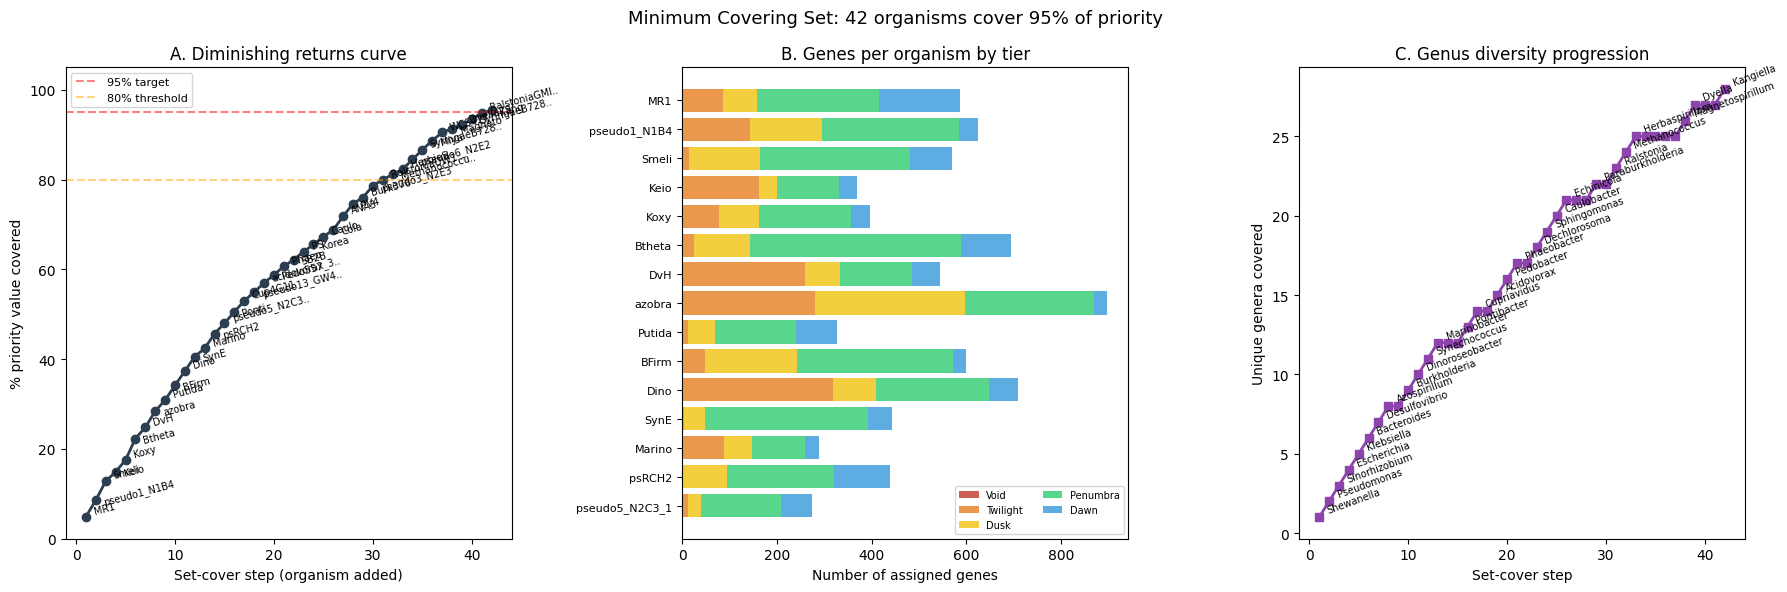

Saved fig26_covering_set.png


In [11]:
# Figure 26: Covering Set
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Panel A: Diminishing returns curve with organism labels
ax = axes[0]
steps = covering_df['step'].values
pct = covering_df['pct_covered'].values
ax.plot(steps, pct, 'o-', color='#2c3e50', linewidth=2, markersize=6)
ax.axhline(y=95, color='red', linestyle='--', alpha=0.5, label='95% target')
ax.axhline(y=80, color='orange', linestyle='--', alpha=0.5, label='80% threshold')

# Label each point with organism name
for i, row in covering_df.iterrows():
    org_label = row['orgId']
    if len(org_label) > 12:
        org_label = org_label[:12] + '..'
    offset_y = 2 if i % 2 == 0 else -3
    ax.annotate(org_label, (row['step'], row['pct_covered']),
                textcoords='offset points', xytext=(5, offset_y),
                fontsize=7, rotation=15)

ax.set_xlabel('Set-cover step (organism added)')
ax.set_ylabel('% priority value covered')
ax.set_title('A. Diminishing returns curve')
ax.legend(fontsize=8)
ax.set_ylim(0, 105)

# Panel B: Per-organism stacked bar by darkness tier
ax = axes[1]
# Only show top organisms from covering set (first N steps or until too many)
n_show = min(len(covering_df), 15)
show_orgs = covering_df['orgId'].values[:n_show]

tier_names_ordered = ['T1_Void', 'T2_Twilight', 'T3_Dusk', 'T4_Penumbra', 'T5_Dawn']
tier_colors = {'T1_Void': '#c0392b', 'T2_Twilight': '#e67e22',
               'T3_Dusk': '#f1c40f', 'T4_Penumbra': '#2ecc71', 'T5_Dawn': '#3498db'}

bottom = np.zeros(n_show)
for tier in tier_names_ordered:
    counts = []
    for org in show_orgs:
        org_genes = assignments_df[assignments_df['assigned_organism'] == org]
        counts.append((org_genes['darkness_tier'] == tier).sum())
    ax.barh(range(n_show), counts, left=bottom, color=tier_colors[tier],
            label=tier.split('_')[1], alpha=0.8)
    bottom += np.array(counts)

ax.set_yticks(range(n_show))
short_names = [o if len(o) <= 15 else o[:15] + '..' for o in show_orgs]
ax.set_yticklabels(short_names, fontsize=8)
ax.invert_yaxis()
ax.set_xlabel('Number of assigned genes')
ax.set_title('B. Genes per organism by tier')
ax.legend(fontsize=7, ncol=2)

# Panel C: Genus coverage progression
ax = axes[2]
genera_seen = set()
genus_progression = []
for _, row in covering_df.iterrows():
    genera_seen.add(row['genus'])
    genus_progression.append(len(genera_seen))

ax.plot(covering_df['step'].values, genus_progression, 's-',
        color='#8e44ad', linewidth=2, markersize=6)
ax.set_xlabel('Set-cover step')
ax.set_ylabel('Unique genera covered')
ax.set_title('C. Genus diversity progression')
# Annotate new genera
genera_so_far = set()
for i, row in covering_df.iterrows():
    g = row['genus']
    if g not in genera_so_far:
        genera_so_far.add(g)
        ax.annotate(g, (row['step'], genus_progression[i]),
                    textcoords='offset points', xytext=(5, 3),
                    fontsize=7, rotation=20)

plt.suptitle(f'Minimum Covering Set: {len(covering_df)} organisms cover '
             f'{covered_priority/total_priority*100:.0f}% of priority', fontsize=13)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'fig26_covering_set.png'), dpi=150, bbox_inches='tight')
plt.show()
plt.show()
print('Saved fig26_covering_set.png')

## Section 3: Experimental Action Plan

For each covering organism, classify its genes as **hypothesis-bearing** (specific condition recommendation) vs. **darkest** (broad screen), and generate condition recommendations.

Condition hierarchy:
1. Fitness data: top_condition from NB05 scoring
2. Neighbor keywords: functional inference from NB07
3. Module prediction: from NB01 integration
4. Broad screen: for T1/T2 genes with no functional clues

In [12]:
# Condition recommendation engine
KEYWORD_TO_CONDITION = {
    'transport': 'carbon/nitrogen source panel',
    'permease': 'carbon/nitrogen source panel',
    'iron': 'iron limitation/excess',
    'sulfur': 'sulfur source panel',
    'nitrogen': 'nitrogen source panel',
    'flagell': 'motility/soft agar',
    'chemotaxis': 'motility/soft agar',
    'membrane': 'membrane stress (SDS, EDTA)',
    'oxidase': 'oxidative stress (H2O2, paraquat)',
    'reductase': 'electron acceptor panel',
    'kinase': 'signaling conditions (osmotic, pH)',
    'regulator': 'regulatory screen (stress panel)',
    'ribosom': 'translation stress (antibiotics)',
    'protease': 'protein stress (heat, ethanol)',
    'secretion': 'secretion assays',
    'atp': 'energy metabolism panel',
    'nad': 'redox conditions panel',
    'phospho': 'phosphate limitation',
    'dehydrogenase': 'electron donor panel',
    'synthase': 'biosynthesis conditions',
}

def recommend_condition(row):
    """Determine experimental condition for a gene based on evidence hierarchy."""
    # Level 1: Direct fitness data
    top_cond = str(row.get('top_condition_class', ''))
    if top_cond and top_cond not in ('', 'nan', 'None'):
        return top_cond, 'fitness_data'

    # Level 2: Neighbor functional keywords
    func_kw = str(row.get('func_keywords', ''))
    if func_kw and func_kw not in ('', 'nan'):
        for kw, cond in KEYWORD_TO_CONDITION.items():
            if kw in func_kw:
                return cond, 'neighbor_keyword'

    # Level 3: Module prediction
    pred = str(row.get('module_prediction', ''))
    if pred and pred not in ('', 'nan'):
        return f'module-predicted: {pred[:40]}', 'module_prediction'

    # Level 4: Broad screen for darkest genes
    return 'broad_screen', 'no_clue'

# Apply to all assigned genes
# First, merge func_keywords and module_prediction into assignments
assign_enriched = assignments_df.merge(
    census[['orgId', 'locusId', 'module_prediction']],
    on=['orgId', 'locusId'], how='left'
)
# Merge func_keywords from neighbor context
assign_enriched = assign_enriched.merge(
    neighbors[['orgId', 'locusId', 'func_keywords']],
    on=['orgId', 'locusId'], how='left'
)

conditions = []
sources = []
for _, row in assign_enriched.iterrows():
    cond, src = recommend_condition(row)
    conditions.append(cond)
    sources.append(src)

assign_enriched['recommended_condition'] = conditions
assign_enriched['condition_source'] = sources

# Classify hypothesis-bearing vs darkest
assign_enriched['is_hypothesis_bearing'] = assign_enriched['condition_source'] != 'no_clue'

print('Condition recommendation results:')
print(assign_enriched['condition_source'].value_counts().to_string())
print(f'\nHypothesis-bearing: {assign_enriched["is_hypothesis_bearing"].sum():,}')
print(f'Darkest (broad screen): {(~assign_enriched["is_hypothesis_bearing"]).sum():,}')

print(f'\nTop recommended conditions:')
print(assign_enriched['recommended_condition'].value_counts().head(15).to_string())

Condition recommendation results:
condition_source
neighbor_keyword     8944
fitness_data         5481
no_clue              2038
module_prediction      25

Hypothesis-bearing: 14,450
Darkest (broad screen): 2,038

Top recommended conditions:
recommended_condition
carbon/nitrogen source panel          3828
stress                                2952
broad_screen                          2038
carbon source                         1144
membrane stress (SDS, EDTA)           1084
regulatory screen (stress panel)       822
electron acceptor panel                792
nitrogen source                        628
signaling conditions (osmotic, pH)     510
motility/soft agar                     456
oxidative stress (H2O2, paraquat)      257
motility                               198
phosphate limitation                   183
iron limitation/excess                 156
energy metabolism panel                152


In [13]:
# Aggregate per-organism action plan
action_plans = []

for _, step_row in covering_df.iterrows():
    org = step_row['orgId']
    org_genes = assign_enriched[assign_enriched['assigned_organism'] == org].copy()
    if len(org_genes) == 0:
        continue

    n_total = len(org_genes)
    n_hypothesis = org_genes['is_hypothesis_bearing'].sum()
    n_darkest = n_total - n_hypothesis
    n_essential = org_genes['is_essential_dark'].fillna(False).sum()
    tractability = CRISPRI_TRACTABILITY.get(org, DEFAULT_CRISPRI)

    # Top conditions
    hyp_genes = org_genes[org_genes['is_hypothesis_bearing']]
    top_conds = hyp_genes['recommended_condition'].value_counts().head(5)
    top_cond_str = '; '.join(f'{c}({n})' for c, n in top_conds.items())

    # Experiment type
    if n_hypothesis > n_darkest:
        experiment_type = 'targeted'
    elif n_darkest > n_hypothesis * 2:
        experiment_type = 'broad_screen'
    else:
        experiment_type = 'mixed'

    # Tier distribution
    tier_dist = org_genes['darkness_tier'].value_counts().to_dict()

    # Mean composite score
    mean_score = org_genes['composite_score'].mean()

    action_plans.append({
        'orgId': org,
        'genus': step_row['genus'],
        'covering_step': int(step_row['step']),
        'n_total_genes': n_total,
        'n_hypothesis_bearing': int(n_hypothesis),
        'n_darkest': n_darkest,
        'n_essential': int(n_essential),
        'tractability': tractability,
        'experiment_type': experiment_type,
        'top_conditions': top_cond_str,
        'mean_composite_score': mean_score,
        'n_T1': tier_dist.get('T1_Void', 0),
        'n_T2': tier_dist.get('T2_Twilight', 0),
        'n_T3': tier_dist.get('T3_Dusk', 0),
        'n_T4': tier_dist.get('T4_Penumbra', 0),
        'n_T5': tier_dist.get('T5_Dawn', 0),
    })

action_df = pd.DataFrame(action_plans)
action_df.to_csv(os.path.join(DATA_DIR, 'experimental_action_plan.tsv'), sep='\t', index=False)
print(f'Saved experimental_action_plan.tsv ({len(action_df)} organisms)')

# Verification
print(f'\nVerification:')
for _, row in action_df.iterrows():
    assert row['n_hypothesis_bearing'] + row['n_darkest'] == row['n_total_genes'], \
        f'{row["orgId"]}: hypothesis + darkest != total'
print('  hypothesis + darkest sums verified for all organisms')

print(f'\nAction plan summary:')
print(action_df[['orgId', 'n_total_genes', 'n_hypothesis_bearing', 'n_darkest',
                 'n_essential', 'tractability', 'experiment_type']].to_string(index=False))

Saved experimental_action_plan.tsv (42 organisms)

Verification:
  hypothesis + darkest sums verified for all organisms

Action plan summary:
                  orgId  n_total_genes  n_hypothesis_bearing  n_darkest  n_essential  tractability experiment_type
                    MR1            587                   544         43          190          0.80        targeted
           pseudo1_N1B4            624                   544         80          455          0.70        targeted
                  Smeli            570                   529         41          323          0.60        targeted
                   Keio            368                   259        109          205          0.90        targeted
                   Koxy            396                   365         31          193          0.65        targeted
                 Btheta            693                   657         36          241          0.30        targeted
                    DvH            545               

In [14]:
# Narrative dossiers for top 5 organisms
print('=' * 80)
print('EXPERIMENTAL DOSSIERS — TOP 5 COVERING ORGANISMS')
print('=' * 80)

for i, (_, plan) in enumerate(action_df.head(5).iterrows()):
    org = plan['orgId']
    org_genes = assign_enriched[assign_enriched['assigned_organism'] == org].copy()
    org_genes = org_genes.sort_values('composite_score', ascending=False)

    print(f'\n{"=" * 70}')
    print(f'Organism #{i+1}: {org} ({plan["genus"]})')
    print(f'{"=" * 70}')
    print(f'  Tractability: {plan["tractability"]} (CRISPRi score)')
    print(f'  Total genes: {plan["n_total_genes"]:,}')
    print(f'  Hypothesis-bearing: {plan["n_hypothesis_bearing"]:,}')
    print(f'  Darkest (broad screen): {plan["n_darkest"]}')
    print(f'  Essential: {plan["n_essential"]}')
    print(f'  Experiment type: {plan["experiment_type"]}')
    print(f'  Top conditions: {plan["top_conditions"]}')

    # Top 10 hypothesis-bearing genes
    hyp_genes = org_genes[org_genes['is_hypothesis_bearing']].head(10)
    if len(hyp_genes) > 0:
        print(f'\n  TOP 10 HYPOTHESIS-BEARING GENES:')
        for j, (_, g) in enumerate(hyp_genes.iterrows()):
            print(f'    {j+1}. {g["locusId"]:15s} score={g["composite_score"]:.3f} '
                  f'tier={g["darkness_tier"]:12s} '
                  f'cond={g["recommended_condition"]}')
            if g.get('evidence_summary') and str(g['evidence_summary']) != 'nan':
                print(f'       evidence: {str(g["evidence_summary"])[:100]}')

    # Top 5 darkest genes
    dark_genes = org_genes[~org_genes['is_hypothesis_bearing']].head(5)
    if len(dark_genes) > 0:
        print(f'\n  TOP 5 DARKEST GENES (broad screen recommended):')
        for j, (_, g) in enumerate(dark_genes.iterrows()):
            print(f'    {j+1}. {g["locusId"]:15s} score={g["composite_score"]:.3f} '
                  f'tier={g["darkness_tier"]:12s} '
                  f'desc={str(g.get("desc", ""))[:50]}')

EXPERIMENTAL DOSSIERS — TOP 5 COVERING ORGANISMS

Organism #1: MR1 (Shewanella)
  Tractability: 0.8 (CRISPRi score)
  Total genes: 587
  Hypothesis-bearing: 544
  Darkest (broad screen): 43
  Essential: 190
  Experiment type: targeted
  Top conditions: stress(161); nitrogen source(74); carbon source(66); carbon/nitrogen source panel(48); motility(38)

  TOP 10 HYPOTHESIS-BEARING GENES:
    1. 200382          score=0.899 tier=T4_Penumbra  cond=translation stress (antibiotics)
       evidence: 2 domain(s); OG:OG00167; essential; pangenome; +synteny,neighbor_inf
    2. 201473          score=0.860 tier=T4_Penumbra  cond=motility/soft agar
       evidence: 2 domain(s); OG:OG01878; essential; pangenome; +synteny,neighbor_inf
    3. 200359          score=0.856 tier=T4_Penumbra  cond=electron acceptor panel
       evidence: 2 domain(s); OG:OG01575; essential; pangenome; +synteny,neighbor_inf
    4. 200343          score=0.844 tier=T4_Penumbra  cond=membrane stress (SDS, EDTA)
       evidence: 

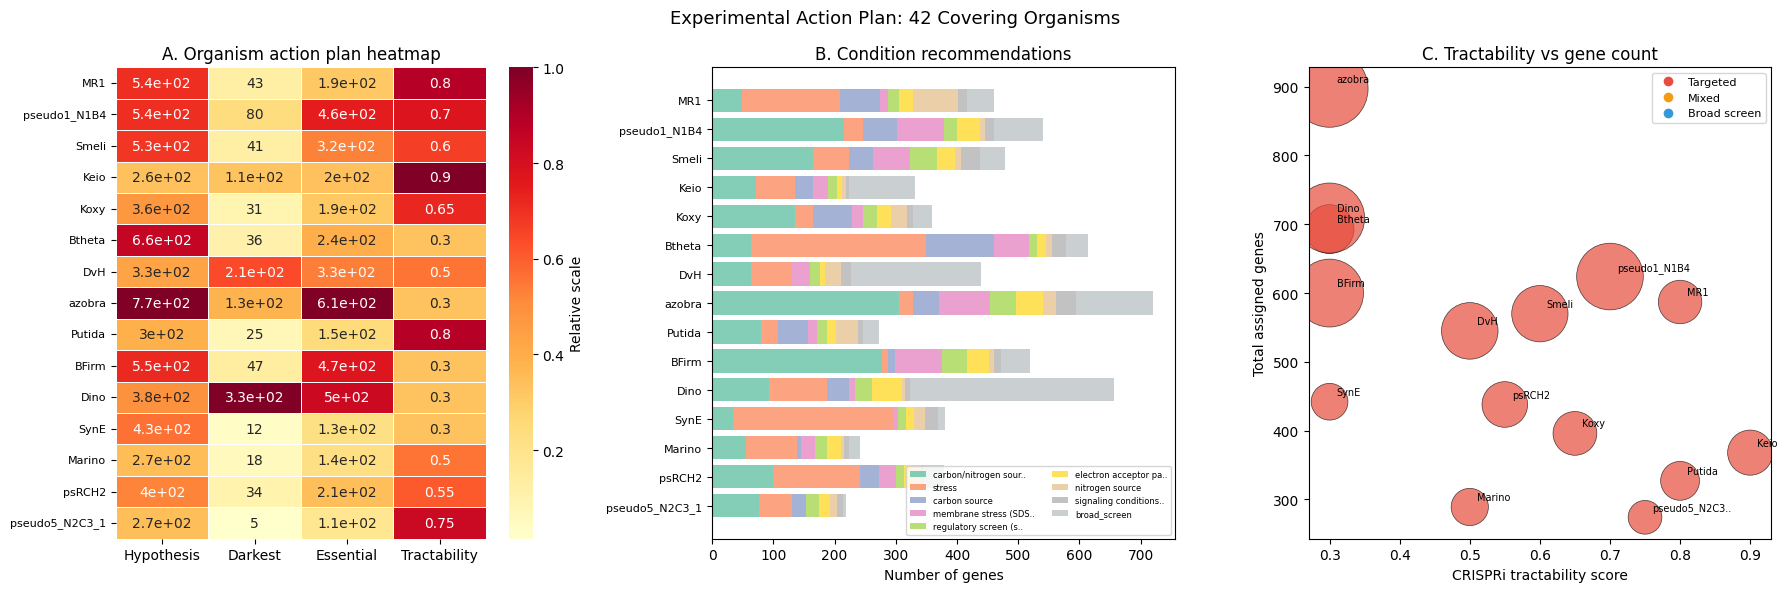

Saved fig27_action_plan.png


In [15]:
# Figure 27: Action Plan
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Panel A: Organism heatmap (n_hypothesis/n_darkest/n_essential/tractability)
ax = axes[0]
heatmap_cols = ['n_hypothesis_bearing', 'n_darkest', 'n_essential', 'tractability']
heatmap_labels = ['Hypothesis', 'Darkest', 'Essential', 'Tractability']
n_show = min(len(action_df), 15)
heatmap_data = action_df[heatmap_cols].head(n_show).copy()

# Normalize each column to 0-1 for display
for col in heatmap_cols:
    col_max = heatmap_data[col].max()
    if col_max > 0:
        heatmap_data[col] = heatmap_data[col] / col_max

sns.heatmap(heatmap_data.values, ax=ax, cmap='YlOrRd',
            xticklabels=heatmap_labels,
            yticklabels=[o if len(o) <= 15 else o[:15]+'..' for o in action_df['orgId'].head(n_show)],
            annot=action_df[['n_hypothesis_bearing', 'n_darkest', 'n_essential', 'tractability']].head(n_show).values,
            fmt='.2g', linewidths=0.5, cbar_kws={'label': 'Relative scale'})
ax.set_title('A. Organism action plan heatmap')
ax.tick_params(axis='y', labelsize=8)

# Panel B: Condition class stacked bars per organism
ax = axes[1]
show_orgs = action_df['orgId'].head(n_show).values

# Get top condition classes across all organisms
all_conds = assign_enriched[assign_enriched['is_hypothesis_bearing']]['recommended_condition'].value_counts()
top_cond_classes = all_conds.head(8).index.tolist()
cond_colors = plt.cm.Set2(np.linspace(0, 1, len(top_cond_classes)))

bottom = np.zeros(n_show)
for ci, cond_class in enumerate(top_cond_classes):
    counts = []
    for org in show_orgs:
        org_hyp = assign_enriched[(assign_enriched['assigned_organism'] == org) &
                                  (assign_enriched['is_hypothesis_bearing'])]
        counts.append((org_hyp['recommended_condition'] == cond_class).sum())
    label = cond_class if len(cond_class) <= 20 else cond_class[:20] + '..'
    ax.barh(range(n_show), counts, left=bottom, color=cond_colors[ci],
            label=label, alpha=0.8)
    bottom += np.array(counts)

# Add broad_screen counts
broad_counts = []
for org in show_orgs:
    org_broad = assign_enriched[(assign_enriched['assigned_organism'] == org) &
                                (~assign_enriched['is_hypothesis_bearing'])]
    broad_counts.append(len(org_broad))
ax.barh(range(n_show), broad_counts, left=bottom, color='#bdc3c7',
        label='broad_screen', alpha=0.8)

ax.set_yticks(range(n_show))
ax.set_yticklabels([o if len(o) <= 15 else o[:15]+'..' for o in show_orgs], fontsize=8)
ax.invert_yaxis()
ax.set_xlabel('Number of genes')
ax.set_title('B. Condition recommendations')
ax.legend(fontsize=6, loc='lower right', ncol=2)

# Panel C: Tractability vs gene count scatter
ax = axes[2]
sizes = action_df['n_essential'].head(n_show) * 5 + 30
colors_scatter = ['#e74c3c' if t == 'targeted' else '#3498db' if t == 'broad_screen' else '#f39c12'
                  for t in action_df['experiment_type'].head(n_show)]

ax.scatter(action_df['tractability'].head(n_show),
           action_df['n_total_genes'].head(n_show),
           s=sizes, c=colors_scatter, alpha=0.7, edgecolors='black', linewidths=0.5)

for _, row in action_df.head(n_show).iterrows():
    org_label = row['orgId'] if len(row['orgId']) <= 12 else row['orgId'][:12] + '..'
    ax.annotate(org_label, (row['tractability'], row['n_total_genes']),
                textcoords='offset points', xytext=(5, 5), fontsize=7)

ax.set_xlabel('CRISPRi tractability score')
ax.set_ylabel('Total assigned genes')
ax.set_title('C. Tractability vs gene count')
# Legend for experiment types
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#e74c3c', markersize=8, label='Targeted'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#f39c12', markersize=8, label='Mixed'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#3498db', markersize=8, label='Broad screen'),
]
ax.legend(handles=legend_elements, fontsize=8)

plt.suptitle(f'Experimental Action Plan: {len(action_df)} Covering Organisms', fontsize=13)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'fig27_action_plan.png'), dpi=150, bbox_inches='tight')
plt.show()
plt.show()
print('Saved fig27_action_plan.png')

In [16]:
# Summary statistics
print('=' * 70)
print('NB09 SUMMARY: FINAL SYNTHESIS')
print('=' * 70)

print(f'\n--- Darkness Spectrum ---')
print(f'Total dark genes classified: {len(census):,}')
for tier in ['T1_Void', 'T2_Twilight', 'T3_Dusk', 'T4_Penumbra', 'T5_Dawn']:
    n = (census['darkness_tier'] == tier).sum()
    scored_n = census[(census['darkness_tier'] == tier) & census['composite_score'].notna()].shape[0]
    print(f'  {tier:15s}: {n:>6,} ({100*n/len(census):5.1f}%), {scored_n:,} with composite score')

print(f'\n--- Minimum Covering Set ---')
print(f'Organisms selected: {len(covering_df)}')
print(f'Genes assigned: {len(assignments_df):,}')
print(f'Priority coverage: {covered_priority/total_priority*100:.1f}%')
print(f'Unique genera: {len(selected_genera)}')

# How many organisms for 80% coverage?
for _, row in covering_df.iterrows():
    if row['pct_covered'] >= 80:
        print(f'80% coverage reached at step {int(row["step"])} ({row["orgId"]})')
        break

print(f'\n--- Experimental Action Plan ---')
total_hyp = action_df['n_hypothesis_bearing'].sum()
total_dark = action_df['n_darkest'].sum()
total_ess = action_df['n_essential'].sum()
print(f'Hypothesis-bearing genes: {total_hyp:,}')
print(f'Darkest (broad screen): {total_dark:,}')
print(f'Essential: {total_ess:,}')
print(f'Experiment types: {action_df["experiment_type"].value_counts().to_dict()}')

print(f'\n--- Output Files ---')
for f in ['dark_gene_census_full.tsv', 'minimum_covering_set.tsv', 'experimental_action_plan.tsv']:
    fp = os.path.join(DATA_DIR, f)
    if os.path.exists(fp):
        df_check = pd.read_csv(fp, sep='\t', nrows=1)
        n_rows = len(pd.read_csv(fp, sep='\t'))
        print(f'  {f}: {n_rows:,} rows, {len(df_check.columns)} columns')
for f in ['fig25_darkness_spectrum.png', 'fig26_covering_set.png', 'fig27_action_plan.png']:
    fp = os.path.join(FIG_DIR, f)
    if os.path.exists(fp):
        print(f'  {f}')

print('\n' + '=' * 70)

NB09 SUMMARY: FINAL SYNTHESIS

--- Darkness Spectrum ---
Total dark genes classified: 57,011
  T1_Void        :  4,273 (  7.5%), 0 with composite score
  T2_Twilight    : 12,282 ( 21.5%), 3,319 with composite score
  T3_Dusk        : 16,103 ( 28.2%), 3,747 with composite score
  T4_Penumbra    : 22,500 ( 39.5%), 8,425 with composite score
  T5_Dawn        :  1,853 (  3.3%), 1,853 with composite score

--- Minimum Covering Set ---
Organisms selected: 42
Genes assigned: 16,488
Priority coverage: 95.4%
Unique genera: 28
80% coverage reached at step 32 (Methanococcus_S2)

--- Experimental Action Plan ---
Hypothesis-bearing genes: 14,450
Darkest (broad screen): 2,038
Essential: 8,900
Experiment types: {'targeted': 41, 'mixed': 1}

--- Output Files ---
  dark_gene_census_full.tsv: 57,011 rows, 30 columns


  minimum_covering_set.tsv: 16,488 rows, 12 columns
  experimental_action_plan.tsv: 42 rows, 16 columns
  fig25_darkness_spectrum.png
  fig26_covering_set.png
  fig27_action_plan.png



In [17]:
# Finding 13 text for REPORT.md
n_covering = len(covering_df)
n_genera = len(selected_genera)
pct_coverage = covered_priority / total_priority * 100
n_assigned = len(assignments_df)
total_hyp = int(action_df['n_hypothesis_bearing'].sum())
total_dark = int(action_df['n_darkest'].sum())
total_ess = int(action_df['n_essential'].sum())
top_org = covering_df.iloc[0]['orgId']
top_org_genes = int(covering_df.iloc[0]['n_new_genes'])

# 80% coverage step
step_80 = None
for _, row in covering_df.iterrows():
    if row['pct_covered'] >= 80:
        step_80 = int(row['step'])
        break

# Tier counts
t1 = int((census['darkness_tier'] == 'T1_Void').sum())
t2 = int((census['darkness_tier'] == 'T2_Twilight').sum())
t3 = int((census['darkness_tier'] == 'T3_Dusk').sum())
t4 = int((census['darkness_tier'] == 'T4_Penumbra').sum())
t5 = int((census['darkness_tier'] == 'T5_Dawn').sum())

print('FINDING 13 TEXT FOR REPORT.md')
print('=' * 70)
print(f"""
### Finding 13: Darkness spectrum classifies {len(census):,} genes into 5 tiers; {n_covering} organisms cover {pct_coverage:.0f}% of actionable dark genes

A comprehensive census of all {len(census):,} dark genes assigns each to a darkness tier based on 6 binary evidence flags (domain annotation, ortholog group, function prediction, co-fitness partner, fitness/essentiality phenotype, pangenome context). The spectrum ranges from T1 Void ({t1:,} genes, 0 evidence lines — truly unknown) through T5 Dawn ({t5:,} genes, 5-6 evidence lines — nearly characterized).

| Tier | Name | Genes | Interpretation |
|------|------|------:|----------------|
| T1 | Void | {t1:,} | No evidence of any kind |
| T2 | Twilight | {t2:,} | Single clue (domain or ortholog only) |
| T3 | Dusk | {t3:,} | Two converging hints |
| T4 | Penumbra | {t4:,} | Substantial evidence — testable hypotheses |
| T5 | Dawn | {t5:,} | Nearly characterized |

Greedy weighted set-cover optimization over the {n_assigned:,} scored dark genes identifies {n_covering} organisms (from {n_genera} genera) that cover {pct_coverage:.0f}% of total priority value. {top_org} ranks first, contributing {top_org_genes:,} genes{f"; {step_80} organisms suffice for 80% coverage" if step_80 else ""}. Per-organism action plans classify genes as hypothesis-bearing ({total_hyp:,} with specific condition recommendations from fitness data, neighbor context, or module predictions) vs. darkest ({total_dark:,} requiring broad phenotypic screens). {total_ess:,} essential genes are flagged for CRISPRi-based approaches.

![Darkness spectrum](figures/fig25_darkness_spectrum.png)

![Minimum covering set](figures/fig26_covering_set.png)

![Experimental action plan](figures/fig27_action_plan.png)

*(Notebook: 09_final_synthesis.ipynb)*
""")

FINDING 13 TEXT FOR REPORT.md

### Finding 13: Darkness spectrum classifies 57,011 genes into 5 tiers; 42 organisms cover 95% of actionable dark genes

A comprehensive census of all 57,011 dark genes assigns each to a darkness tier based on 6 binary evidence flags (domain annotation, ortholog group, function prediction, co-fitness partner, fitness/essentiality phenotype, pangenome context). The spectrum ranges from T1 Void (4,273 genes, 0 evidence lines — truly unknown) through T5 Dawn (1,853 genes, 5-6 evidence lines — nearly characterized).

| Tier | Name | Genes | Interpretation |
|------|------|------:|----------------|
| T1 | Void | 4,273 | No evidence of any kind |
| T2 | Twilight | 12,282 | Single clue (domain or ortholog only) |
| T3 | Dusk | 16,103 | Two converging hints |
| T4 | Penumbra | 22,500 | Substantial evidence — testable hypotheses |
| T5 | Dawn | 1,853 | Nearly characterized |

Greedy weighted set-cover optimization over the 16,488 scored dark genes identifies 42 or